# Modeling - Complex Model (CNN and RNN Layers with Embedded LSTM)

In [1]:
# import necessary packages
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle

In [2]:
def load_az_dataset(datasetPath):
    # initialize the list of data and labels
    data = []
    labels = []
    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(datasetPath):
        # parse the label and image from the row
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and repshape them into a 28x28 matrix
        image = image.reshape((28, 28, 1))
        # update the list of data and labels
        data.append(image)
        labels.append(label)
    # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")
    # bring values between 0 and 1
    data /= 255.0
    # return a 2-tuple of the A-Z data and labels
    return (data, labels)

In [3]:
# retreive data and labels using our function defined above
data, labels = load_az_dataset('data/NIST_SD19/A_Z Handwritten Data/A_Z Handwritten Data.csv')

In [4]:
# define labels
alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in alpha]

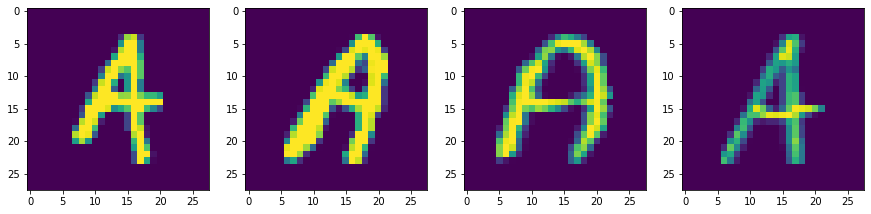

In [5]:
# plot first four images in data
fig, axs = plt.subplots(1, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(4):
    axs[i].imshow(data[i])

In [6]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [7]:
# split data and labels into train, test, validation
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")

In [9]:
# define model and retrieve a summary
def build_model():
    # Inputs to the model
    inp = tf.keras.Input(shape=(28, 28, 1), name="image")

    # First conv block.
    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(inp)
    # x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    # x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # The number of filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = (28, (28 * 64))
    x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    
    # flatten
    x = tf.keras.layers.Flatten()(x)

    output = tf.keras.layers.Dense(
        len(labelNames), activation="softmax", name="dense2"
    )(x)

    # Define the model.
    model = tf.keras.models.Model(
        inputs=inp, outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = tf.keras.optimizers.Adam()
    
    # Compile the model and return.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 28, 28, 32)        320       
                                                                 
 Conv2 (Conv2D)              (None, 28, 28, 64)        18496     
                                                                 
 reshape (Reshape)           (None, 28, 1792)          0         
                                                                 
 dense1 (Dense)              (None, 28, 64)            114752    
                                                                 
 dropout (Dropout)           (None, 28, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 28, 256

In [10]:
# train model and produce history artifact

model = build_model()
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

history = model.fit(
    aug.flow(X_train, y_train, batch_size=128),
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50
1863/1863 [==============================] - 65s 31ms/step - loss: 0.2251 - accuracy: 0.9328 - val_loss: 0.0633 - val_accuracy: 0.9832
Epoch 2/50
1863/1863 [==============================] - 58s 31ms/step - loss: 0.0909 - accuracy: 0.9733 - val_loss: 0.0554 - val_accuracy: 0.9857
Epoch 3/50
1863/1863 [==============================] - 58s 31ms/step - loss: 0.0730 - accuracy: 0.9785 - val_loss: 0.0482 - val_accuracy: 0.9865
Epoch 4/50
1863/1863 [==============================] - 57s 31ms/step - loss: 0.0627 - accuracy: 0.9814 - val_loss: 0.0446 - val_accuracy: 0.9879
Epoch 5/50
1863/1863 [==============================] - 58s 31ms/step - loss: 0.0572 - accuracy: 0.9831 - val_loss: 0.0454 - val_accuracy: 0.9873
Epoch 6/50
1863/1863 [==============================] - 57s 31ms/step - loss: 0.0525 - accuracy: 0.9844 - val_loss: 0.0362 - val_accuracy: 0.9899
Epoch 7/50
1863/1863 [==============================] - 58s 31ms/step - loss: 0.0485 - accuracy: 0.9856 - val_loss: 0.0339 -

In [11]:
# save model
model.save('model/Complex.h5')

In [12]:
# save model history
with open('hist/Complex.hist', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

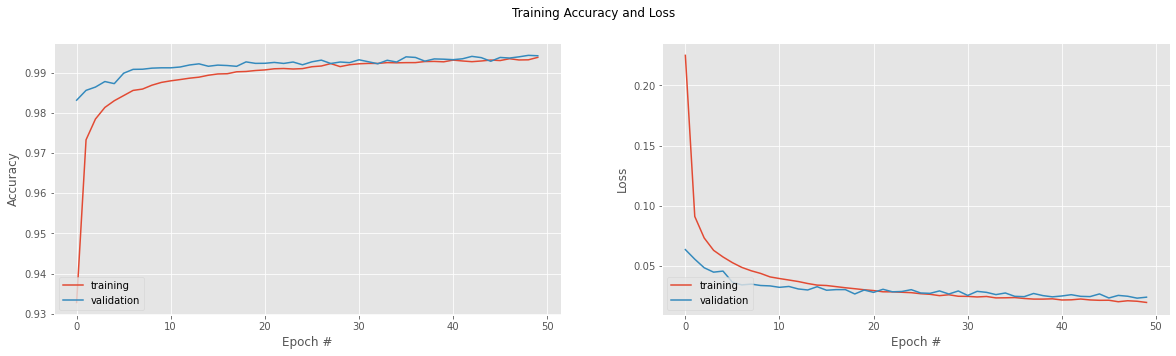

In [13]:
# show plots of both accuracy and loss vs training epochs
N = np.arange(0, 50)
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 2)

fig.suptitle('Training Accuracy and Loss')
fig.set_figheight(5)
fig.set_figwidth(20)

ax[0].plot(N, history.history["accuracy"], label="training")
ax[0].plot(N, history.history["val_accuracy"], label="validation")
ax[0].set(xlabel='Epoch #', ylabel='Accuracy')
ax[0].legend(loc="lower left")

ax[1].plot(N, history.history["loss"], label="training")
ax[1].plot(N, history.history["val_loss"], label="validation")
ax[1].set(xlabel='Epoch #', ylabel='Loss')
ax[1].legend(loc="lower left")

In [14]:
# save the above figure
fig.savefig('hist/Complex.pdf', bbox_inches='tight')

In [15]:
# produce predictions on test set and display classification report
predictions = model.predict(X_test[:3000])
print(classification_report(y_test[:3000].argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           B       1.00      0.98      0.99        64
           C       1.00      1.00      1.00       201
           D       0.97      0.99      0.98        67
           E       1.00      1.00      1.00        78
           F       1.00      1.00      1.00         8
           G       1.00      0.98      0.99        41
           H       1.00      1.00      1.00        55
           I       1.00      1.00      1.00         9
           J       0.99      0.99      0.99        68
           K       1.00      1.00      1.00        41
           L       0.99      1.00      0.99        85
           M       0.98      1.00      0.99       100
           N       1.00      0.99      0.99       186
           O       0.99      0.99      0.99       480
           P       1.00      1.00      1.00       150
           Q       1.00      0.96      0.98        55
           R       1.00    